# **Importing the Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data1 = pd.read_csv("/content/drive/My Drive/DataThesis/BETN073/BETN073-1990_2012.csv")
data2 = pd.read_csv("/content/drive/My Drive/DataThesis/BETN073/BETN073-2013_2022.csv")
ozone_data = pd.concat([data1,data2])
ozone_data = ozone_data.reset_index()

# **Preprocessing**

Select the data where that will be used for the model which includes the hourly data from 2008 to 2019. The unnecessary columns are moved to only keep the columns with concentration values and the date and time at which each concentration is measured.

In [3]:
columns_remove = ['Samplingpoint','Pollutant','End','Unit','AggType','Validity','Verification','ResultTime','DataCapture','FkObservationLog','index']
ozone_data = ozone_data.drop(columns=columns_remove)

# Sampling Point: BE/SPO-BETN073_00007_100
# Pollutant: 7 (O_3)
# End: Start with 1 hour added
# Unit: ug.m-3
# Aggregation Type: hour
# Validaity/Verification: 1 & 1
# Result Time: Time and Date when data is added to the whole data file
# Data Capture: 0
# FkObservation log: Do not know meaning, values from NaN to 0fa5da4d-ae92-4bb7-bcd4-07fb6b962ae4

ozone_data['Start'] = pd.to_datetime(ozone_data['Start'])
data = ozone_data[(ozone_data['Start'].dt.year >= 2008) & (ozone_data['Start'].dt.year <= 2019)]
data = data.reset_index()
data = data.drop(columns=['index'])
data.rename(columns={'Value': 'Concentration'}, inplace=True)

Thus the following dataframe only

In [4]:
data.head()

,Start,Concentration
0,2008-01-01 00:00:00,0.0
1,2008-01-01 01:00:00,1.0
2,2008-01-01 02:00:00,0.0
3,2008-01-01 03:00:00,2.0
4,2008-01-01 04:00:00,1.0


The data is checked to make sure there are no duplicates.

In [5]:
duplicates = data.duplicated(subset=['Start'])

# Print or further process the duplicate values
print("Duplicate values in the column Start:", duplicates.any())

Duplicate values in the column Start: False


## Adding new variables

From the Start column, we extracr the year, month, day and time.

In [6]:
# Extract year, month, day, and time into separate columns
data['Year'] = data['Start'].dt.year
data['Month'] = data['Start'].dt.month
data['Day'] = data['Start'].dt.day
data['Time'] = data['Start'].dt.time

# Display the transformed DataFrame
print(data.head())

                Start  Concentration  Year  Month  Day      Time
0 2008-01-01 00:00:00            0.0  2008      1    1  00:00:00
1 2008-01-01 01:00:00            1.0  2008      1    1  01:00:00
2 2008-01-01 02:00:00            0.0  2008      1    1  02:00:00
3 2008-01-01 03:00:00            2.0  2008      1    1  03:00:00
4 2008-01-01 04:00:00            1.0  2008      1    1  04:00:00


From the Start column the day of the week can be extracted, which can also be used to determine if that measurement was taken during the weekend.

In [7]:
# Extract day of the week
data['DayOfWeek'] = (data['Start'].dt.weekday + 1) % 7

# Create a new column indicating whether the day is a weekend or not
data['Weekend'] = (data['Start'].dt.dayofweek // 5).astype(int)

In [8]:
data.head()

,Start,Concentration,Year,Month,Day,Time,DayOfWeek,Weekend
0,2008-01-01 00:00:00,0.0,2008,1,1,00:00:00,2,0
1,2008-01-01 01:00:00,1.0,2008,1,1,01:00:00,2,0
2,2008-01-01 02:00:00,0.0,2008,1,1,02:00:00,2,0
3,2008-01-01 03:00:00,2.0,2008,1,1,03:00:00,2,0
4,2008-01-01 04:00:00,1.0,2008,1,1,04:00:00,2,0


## Converting the negative values

Missing values are represented by negative concentration values. Thus, these will be converted to NaN to be able to used the describe function to attain some basic measures.

In [9]:
# Can check the issue here
data['Concentration'].describe()

count    104495.000000
mean       -472.202526
std        2219.973998
min       -9999.000000
25%          19.000000
50%          42.000000
75%          61.000000
max         238.000000
Name: Concentration, dtype: float64

In [10]:
count_below_zero = (data['Concentration'] < 0).sum()

# Print the count
print("Number of observations with values below 0:", count_below_zero)

data.loc[data['Concentration'] < 0, 'Concentration'] = np.nan

Number of observations with values below 0: 5381


Thus, there are 5381 missing observation for the BETN073 station between the years 2008 and 2019.

In [11]:
data['Concentration'].describe()

count    99114.000000
mean        45.017011
std         28.889379
min          0.000000
25%         23.000000
50%         43.500000
75%         62.000000
max        238.000000
Name: Concentration, dtype: float64

## Making the data daily

In [12]:
# Remove the 'Time' column
data.drop(columns=['Time'], inplace=True)

# Group by 'Year', 'Month', and 'Day', and calculate the daily average concentration
data = data.groupby(['Year', 'Month', 'Day']).agg({'Concentration': 'mean', 'DayOfWeek': 'first', 'Weekend': 'first'}).reset_index()

# Display the daily dataset
print(data.head())

   Year  Month  Day  Concentration  DayOfWeek  Weekend
0  2008      1    1       7.583333          2        0
1  2008      1    2      40.227273          3        0
2  2008      1    3      33.958333          4        0
3  2008      1    4      27.913043          5        0
4  2008      1    5      63.304348          6        1


In [13]:
nan_count = data['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 49


In [14]:
data['Concentration'] = np.interp(data.index, data.dropna().index, data['Concentration'].dropna())

In [15]:
nan_count = data['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 0


# **ARIMA model**

## A new variable based on the optimal SARIMA is made

In [16]:
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

data.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend
Date,,,,,,
2008-01-01,2008,1,1,7.583333,2,0
2008-01-02,2008,1,2,40.227273,3,0
2008-01-03,2008,1,3,33.958333,4,0
2008-01-04,2008,1,4,27.913043,5,0
2008-01-05,2008,1,5,63.304348,6,1


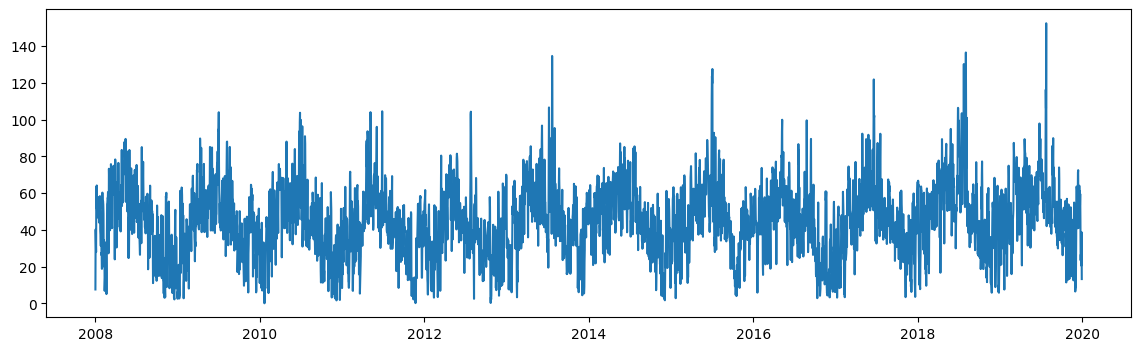

In [17]:
plt.figure(figsize=(14,4))
plt.plot(data.Concentration)

In [18]:
# Drop unnecessary columns
data_a = data[['Concentration']].copy()

# Reset the index to keep it as a regular column
data_a.reset_index(inplace=True)
data_a.set_index('Date', inplace=True)

data_a.head()

,Concentration
Date,
2008-01-01,7.583333
2008-01-02,40.227273
2008-01-03,33.958333
2008-01-04,27.913043
2008-01-05,63.304348


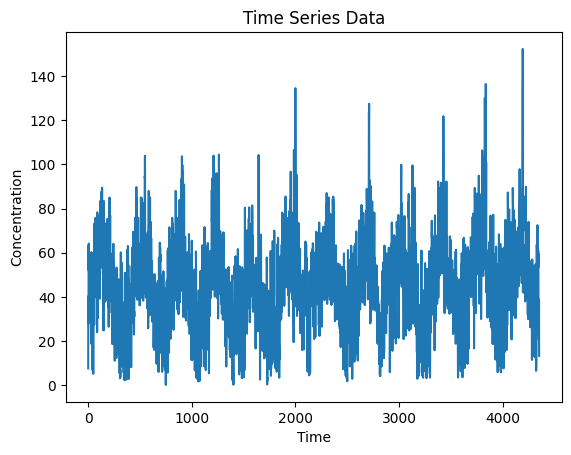

In [19]:
# Extract the 'Concentration' column as a NumPy array
data_b = data['Concentration'].to_numpy()

# Plot the time series data
plt.plot(data_b)
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

In [20]:
data_a.dropna(subset=['Concentration'], inplace=True)

In [21]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data_a)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -6.276048382263732
p-value: 3.89834162941973e-08
Critical Values: {'1%': -3.4318600803649013, '5%': -2.862207269624908, '10%': -2.567125192310325}
The time series is likely stationary.


## Analysed stationarity

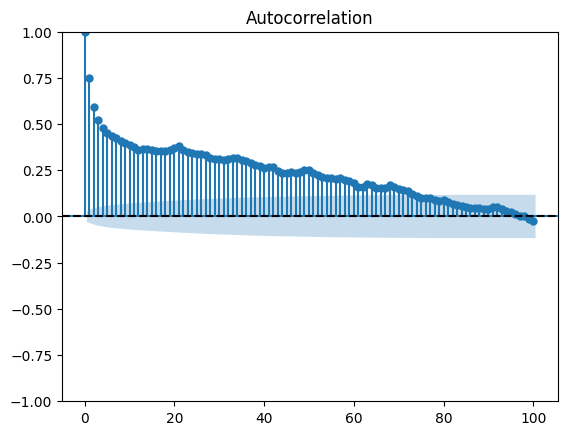

In [22]:
acf_plot = plot_acf(data_a.Concentration, lags=100)
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

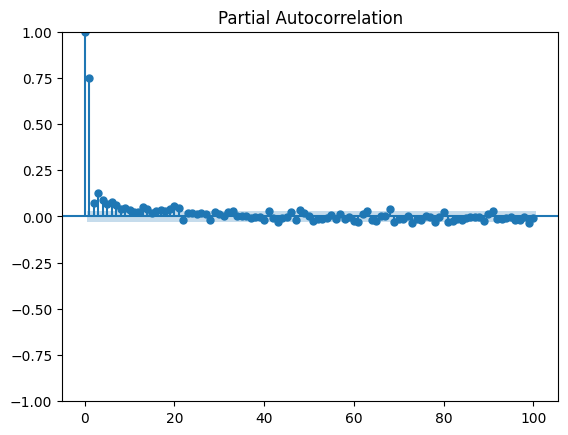

In [23]:
pacf_plot = plot_pacf(data_a.Concentration, lags=100)

In [25]:
data_a = data['Concentration'].to_numpy()

# Define the range of AR and MA values to check
ar_range = range(8)
ma_range = range(8)
s_range = range(2)

# Initialize variables for tracking the best model
best_aic = float('inf')
best_order = None
best_results = None

# Iterate through AR and MA values
for p in ar_range:
    for q in ma_range:
        order = (p, 0, q)  # ARIMA order (p, d, q), here d=0 for ARMA
        model = sm.tsa.ARIMA(data_a, order=order)
        results = model.fit()

        # Calculate Mean Squared Error (MSE)
        fitted_values = results.fittedvalues
        mse = mean_squared_error(data_a, fitted_values)

        # Check if the current model has a lower AIC than the best so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_results = results

            # Update the best MSE as well
            best_mse = mse

# Display the best model's information including AIC, BIC, MSE, and summary
print(f'Best Model Order: {best_order}')
print(f'Best Model AIC: {best_aic:.2f}')
print(f'Best Model BIC: {best_results.bic:.2f}')
print(f'Best Model MSE: {best_mse:.2f}')
print(best_results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

Best Model Order: (4, 0, 1)
Best Model AIC: 34297.56
Best Model BIC: 34342.21
Best Model MSE: 154.04
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4354
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -17141.781
Date:                Mon, 26 Feb 2024   AIC                          34297.561
Time:                        13:10:01   BIC                          34342.213
Sample:                             0   HQIC                         34313.321
                               - 4354                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.8611      2.406     18.645      0.000      40.145      49.577
ar.L1          1.5684      0.0

In [29]:
# Fit ARMA(4, 0, 1) model, the best model
order_arma = best_order  # ARIMA order (p, d, q), here d=0 for ARMA
model_arma = sm.tsa.ARIMA(data_a, order=order_arma)
results_arma = model_arma.fit()

# Extract the predicted (fitted) values
fitted_values = pd.DataFrame({
    'FittedValues': results_arma.fittedvalues
})

# Combine the original data_a DataFrame with the fitted values
data['FittedValues'] = fitted_values['FittedValues']

# Display the updated DataFrame
print(data)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues
Date                                                                         
2008-01-01  2008      1    1       7.583333          2        0           NaN
2008-01-02  2008      1    2      40.227273          3        0           NaN
2008-01-03  2008      1    3      33.958333          4        0           NaN
2008-01-04  2008      1    4      27.913043          5        0           NaN
2008-01-05  2008      1    5      63.304348          6        1           NaN
...          ...    ...  ...            ...        ...      ...           ...
2019-12-27  2019     12   27      26.630435          5        0           NaN
2019-12-28  2019     12   28      22.375000          6        1           NaN
2019-12-29  2019     12   29      20.543478          0        1           NaN
2019-12-30  2019     12   30      38.750000          1        0           NaN
2019-12-31  2019     12   31      13.239130          2        0 

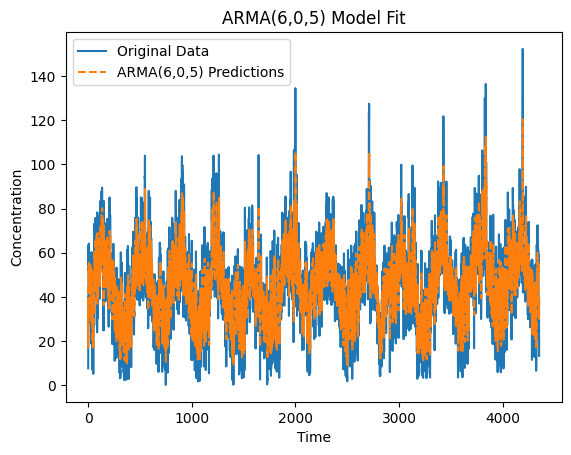

In [30]:
# Plot original data and predicted values
plt.plot(data_a, label='Original Data')
plt.plot(results_arma.fittedvalues, label='ARMA(4,0,1) Predictions', linestyle='--')
plt.title('ARMA(4,0,1) Model Fit')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

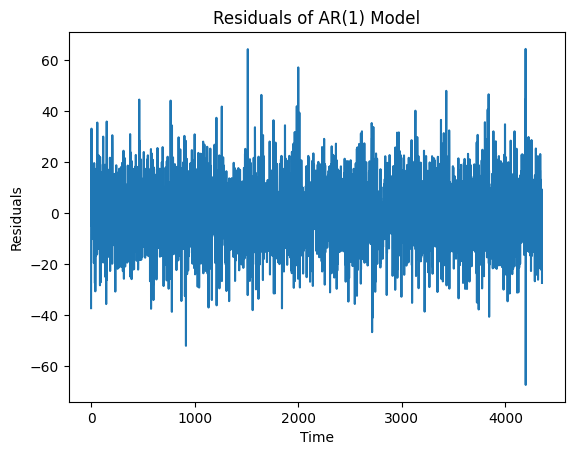

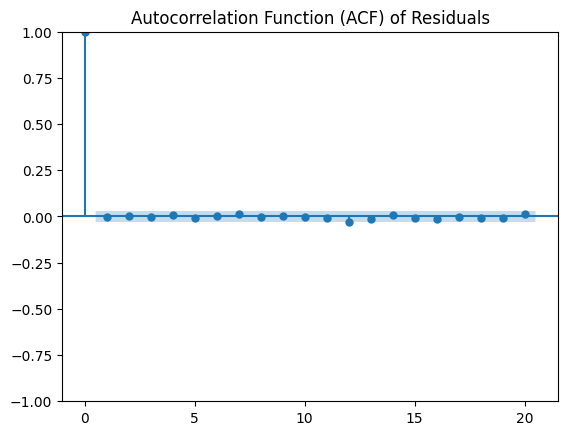

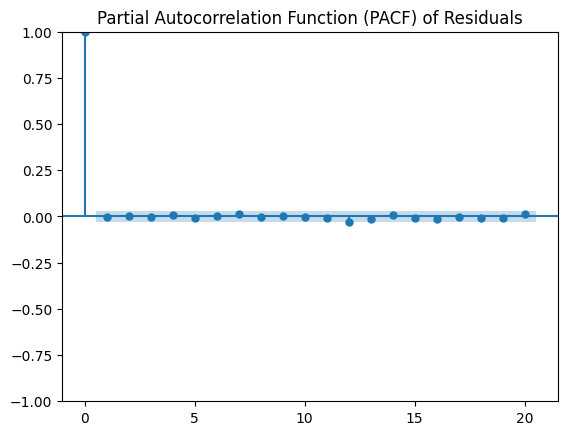

In [31]:
residuals = results_arma.resid

# Plot the residuals
plt.plot(residuals)
plt.title('Residuals of AR(1) Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()


# Plot ACF and PACF of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

plot_pacf(residuals, lags=20)
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.show()

In [32]:
# Remove NaN values from 'Concentration' and 'FittedValues' columns
mask = ~np.isnan(data['Concentration']) & ~np.isnan(data['FittedValues'])
y_true = data['Concentration'][mask]
y_pred = data['FittedValues'][mask]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

The MSE is very high, at

## Now we calculate the lagged values of Concentration (making a new variable with the value from day before, a week before, a month before, and a year before)

In [33]:
# Assuming 'Date' is your index
data['day_lag1'] = data['Concentration'].shift(1)
data['day_lag7'] = data['Concentration'].shift(7)
data['day_lag30'] = data['Concentration'].shift(30)
data['day_lag365'] = data['Concentration'].shift(365)

# If 'Date' is not the index, you can use the following instead
# data['day_lag1'] = data['Concentration'].shift(1).reset_index(drop=True)

print(data.head())

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1       7.583333          2        0           NaN   
2008-01-02  2008      1    2      40.227273          3        0           NaN   
2008-01-03  2008      1    3      33.958333          4        0           NaN   
2008-01-04  2008      1    4      27.913043          5        0           NaN   
2008-01-05  2008      1    5      63.304348          6        1           NaN   

             day_lag1  day_lag7  day_lag30  day_lag365  
Date                                                    
2008-01-01        NaN       NaN        NaN         NaN  
2008-01-02   7.583333       NaN        NaN         NaN  
2008-01-03  40.227273       NaN        NaN         NaN  
2008-01-04  33.958333       NaN        NaN         NaN  
2008-01-05  27.913043       NaN        NaN         NaN  


In [34]:
lag_columns = ['day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## Now we normalize and Converge the signals (days) from euclidian to the angular domain

In [35]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select columns to normalize
columns_to_normalize = ['Concentration', 'FittedValues', 'day_lag1', 'day_lag7']

# Fit and transform the selected columns
data_normalized = data.copy()  # Make a copy to avoid modifying the original data
data_normalized[columns_to_normalize] = scaler.fit_transform(data_normalized[columns_to_normalize])

# Display the normalized data
print(data_normalized)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1       0.049331          2        0           NaN   
2008-01-02  2008      1    2       0.263704          3        0           NaN   
2008-01-03  2008      1    3       0.222536          4        0           NaN   
2008-01-04  2008      1    4       0.182836          5        0           NaN   
2008-01-05  2008      1    5       0.415251          6        1           NaN   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27       0.174413          5        0           NaN   
2019-12-28  2019     12   28       0.146468          6        1           NaN   
2019-12-29  2019     12   29       0.134440          0        1           NaN   
2019-12-30  2019     12   30       0.254002          1        0           NaN   
2019-12-31  2019     12   31

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [36]:
## Assuming data_normalized is the DataFrame with normalized columns
data_restored = data_normalized.copy()

# Inverse transform the selected columns
data_restored[columns_to_normalize] = scaler.inverse_transform(data_normalized[columns_to_normalize])

# Display the restored data
print(data_restored)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1       7.583333          2        0           NaN   
2008-01-02  2008      1    2      40.227273          3        0           NaN   
2008-01-03  2008      1    3      33.958333          4        0           NaN   
2008-01-04  2008      1    4      27.913043          5        0           NaN   
2008-01-05  2008      1    5      63.304348          6        1           NaN   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27      26.630435          5        0           NaN   
2019-12-28  2019     12   28      22.375000          6        1           NaN   
2019-12-29  2019     12   29      20.543478          0        1           NaN   
2019-12-30  2019     12   30      38.750000          1        0           NaN   
2019-12-31  2019     12   31

## Removal of missing values?

In [37]:
# Check for missing values in the 'Concentration' column
rows_with_missing_values = data[data['Concentration'].isna()]

# Display rows with missing values
print("Rows with missing values in 'Concentration' column:")
print(rows_with_missing_values)

Rows with missing values in 'Concentration' column:
Empty DataFrame
Columns: [Year, Month, Day, Concentration, DayOfWeek, Weekend, FittedValues, day_lag1, day_lag7, day_lag30, day_lag365]
Index: []


In [38]:
# Remove rows with null values in the 'Concentration' column in-place
data_normalized.dropna(subset=['Concentration'], inplace=True)

# Display the modified data
print(data_normalized)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1       0.049331          2        0           NaN   
2008-01-02  2008      1    2       0.263704          3        0           NaN   
2008-01-03  2008      1    3       0.222536          4        0           NaN   
2008-01-04  2008      1    4       0.182836          5        0           NaN   
2008-01-05  2008      1    5       0.415251          6        1           NaN   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27       0.174413          5        0           NaN   
2019-12-28  2019     12   28       0.146468          6        1           NaN   
2019-12-29  2019     12   29       0.134440          0        1           NaN   
2019-12-30  2019     12   30       0.254002          1        0           NaN   
2019-12-31  2019     12   31